# Iris all strawberry fields

In [8]:
from qutip import destroy
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors, colorbar, cm
import time
from tqdm.notebook import tqdm
from sklearn.datasets import load_iris

1-moodeののQNNを構成する

In [9]:
def one_mode_variational_quantum_circuit_cubic(params, depth, input_state=None):
    # Gate layer: R-S-R-D-K
    def layer(i, q):
        Rgate(params[i*7+0])                | q
        Sgate(params[i*7+1], params[i*7+2]) | q
        Rgate(params[i*7+3])                | q
        Dgate(params[i*7+4], params[i*7+5]) | q
        Vgate(params[i*7+6])                | q
        return q
    
    # Start SF program
    prog = sf.Program(1)

    # construct the circuit
    with prog.context as q:
        if input_state is not None:
            Ket(input_state) | q
        else:
            Vacuum() | q
        for k in range(depth):
            q = layer(k, q)
    
    eng = sf.Engine("fock", backend_options={"cutoff_dim": dim})
    state = eng.run(prog).state
    ket = state.ket()
    return ket

In [10]:
def one_mode_U(x_0):
    params = (x_0 @ u + v) / 1
    phi = one_mode_variational_quantum_circuit_cubic(params, depth_U)
    return phi

def one_mode_expect_Fock(psi):
    n = np.zeros(dim)
    prob = np.real(np.conjugate(psi) * psi)
    fock_basis = np.arange(dim)
    '''
    prob_posi = 0
    prob_nega = 0
    for i in range(dim):
        if i % 2 == 0:
            prob_posi += prob[i]
        else:
            prob_nega += prob[i]
    '''
    return np.sum(fock_basis * prob) #, prob_posi, prob_nega

def one_mode_expect_X(psi):
    # 測定用の演算子
    x = 1/np.sqrt(2) * (adag + a)
    
    # それぞれのモードをx = 1/√2 (a† + a)で測定
    expect_value = np.conjugate(psi.T) @ x @ psi
    return expect_value

Cost関数を定義。ここではbinary cross entropyとする。

$C(\theta) = -1/N \sum_{n=1}^{N} [t_n \log{y_n} + (1 - t_n) \log{(1 - y_n)}]$

$t_n$は正解の0,1、$y_n$は分類器によって出力された0,1

In [11]:
def discriminator(x_0, params):
    phi = one_mode_U(x_0)
    state = one_mode_variational_quantum_circuit_cubic(params, depth, phi)
    expect_value = one_mode_expect_Fock(state)

    # シグモイド関数により0 - 1にする
    result = 1 / (1 + np.exp(1*(params[7*depth] - expect_value)))
    return result
    
def get_cost(y, t):
    delta = 1e-12 # logの中身が0にならないようにするため
    return -np.sum(t * np.log(y+delta) + (1-t) * np.log(1-y+delta)) / len(y)

def cost(params):
    y = np.zeros(len(t))
    for i in range(len(t)):
        y[i] = discriminator(x[i], params)
    c = get_cost(y, t)
    return c

# callback用の関数
def callback(params):
    params_history.append(params)
    co = cost(params)
    cost_history.append(co)
    print(len(cost_history)-1,'cost', co)

In [12]:
dim = 50
_a = destroy(dim)
a = _a.full()
adag = np.conjugate(a.T)

depth_U = 1
depth_V = 1

# パラメータの決定
g = 1
#np.random.seed(1)
#u = (g*np.random.rand(4,7*depth_U) - g/2) / 1
#v = (g*np.random.rand(7*depth_U) - g/2) / 1

u = np.array([[ 0.08168898, 0.24276392, -0.29024515, -0.08584451,  0.13089175, -0.06598534,
  -0.16098264],
 [ 0.25318717 , 0.42392915,  0.35541263,  0.08061994 , 0.25564774, -0.05363093,
  -0.46506726],
 [-0.19189765, -0.13568203 , 0.28896139 , 0.36715397 , 0.16658188,  0.33236828,
   0.22523654],
 [-0.01756502, -0.47272433,  0.40193263 ,-0.04394104, -0.29321391, -0.12116742,
  -0.31280398]])

v = np.array([-0.47373276,  0.34738809,  0.34484746,  0.18764794, -0.27961507,  0.14020533,
  0.10629507])

print('u',u)
print('v',v)

u [[ 0.08168898  0.24276392 -0.29024515 -0.08584451  0.13089175 -0.06598534
  -0.16098264]
 [ 0.25318717  0.42392915  0.35541263  0.08061994  0.25564774 -0.05363093
  -0.46506726]
 [-0.19189765 -0.13568203  0.28896139  0.36715397  0.16658188  0.33236828
   0.22523654]
 [-0.01756502 -0.47272433  0.40193263 -0.04394104 -0.29321391 -0.12116742
  -0.31280398]]
v [-0.47373276  0.34738809  0.34484746  0.18764794 -0.27961507  0.14020533
  0.10629507]


## 1 2

In [13]:
iris_dataset = load_iris()
print(iris_dataset['target'])

#2値のみ取ってくる（0-99）
x_data_0 = iris_dataset['data'][0:50]
t_data_0 = iris_dataset['target'][0:50]
x_data_1 = iris_dataset['data'][50:100]
t_data_1 = iris_dataset['target'][50:100]
x_data_2 = iris_dataset['data'][100:150]
t_data_2 = iris_dataset['target'][100:150]
x_data = np.concatenate([x_data_1-1, x_data_2-1])
t_data = np.concatenate([t_data_1-1, t_data_2-1])
print(t_data)
print(len(t_data))

# インデックス配列を作成
idx = np.arange(len(x_data))
#np.random.shuffle(idx)
idx_train = idx[idx % 2 == 0]
idx_test = idx[idx % 2 != 0]
# 入力データを訓練データとテストデータに分割
x_train = x_data[idx_train]
x_test = x_data[idx_test]
# クラスデータを訓練データとテストデータに分割
t_train = t_data[idx_train]
t_test = t_data[idx_test]
print(t_train)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
100
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


1 cost 0.6572109165572924
2 cost 0.6552245413976837
3 cost 0.6506823941594198
4 cost 0.6474843635160115
5 cost 0.6420744365504804
6 cost 0.5294134285844321
7 cost 0.5267721949649485
8 cost 0.5224233529156368
9 cost 0.5142623415791571
10 cost 0.4512856160634081
11 cost 0.4272163126464515
12 cost 0.4226850803443958
13 cost 0.3465060999059628
14 cost 0.342040675910166
15 cost 0.33354587620223597
16 cost 0.318077677151947
17 cost 0.26904245893282847
18 cost 0.2630236286971244
19 cost 0.25362960202019186
20 cost 0.24477201709472576
21 cost 0.2414075123185818
22 cost 0.23800938836472307
23 cost 0.23560903779648992
24 cost 0.23390393040986385
25 cost 0.23290321747466547
26 cost 0.231394844529203
27 cost 0.22870718046865504
28 cost 0.21703555212261605
29 cost 0.21333883146776056
30 cost 0.2087236923411016
31 cost 0.2077217823734175
32 cost 0.20690114341869126
33 cost 0.20554596085103305
34 cost 0.20470188865643357
35 cost 0.2040616852917995
36 cost 0.20345501729576315
37 cost 0.202960143573550

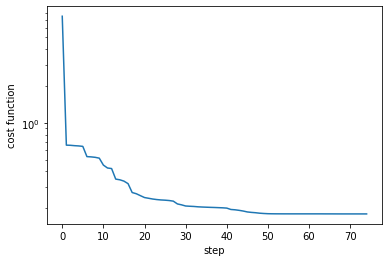

In [14]:
depth = 1

# データ読み込み
x = x_train
t = t_train

# 学習
params = np.random.normal(0, 0.1, [7*depth + 1]) # 最初のパラメータ
maxiter = 100

params_history = []
params_history.append(params)
cost_history = []
cost_history.append(cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}

start = time.perf_counter()
opt = scipy.optimize.minimize(cost, params, method=method,
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()

In [15]:
print('initial parameters:', params_history[0])
print('learnt parameters:', params_history[-1])

print('-------------------------------')
print('train dataset')

learnt_label_train = np.array([0.0 for i in range(len(t_train))])
for i in range(len(learnt_label_train)):
    learnt_label_train[i] = discriminator(x_train[i], params_history[-1])
learnt_label_train = np.round(learnt_label_train).astype(int)
n_miss_train = sum(abs(t_train - learnt_label_train))

print('teacher label', t_train)
print('learnt label ', learnt_label_train)
print('number of mislabel:', n_miss_train)

print('-------------------------------')
print('test dataset')

learnt_label_test = np.array([0.0 for i in range(len(t_test))])
for i in range(len(learnt_label_test)):
    learnt_label_test[i] = discriminator(x_test[i], params_history[-1])
learnt_label_test = np.round(learnt_label_test).astype(int)
n_miss_test = sum(abs(t_test - learnt_label_test))

print('teacher label', t_test)
print('learnt label ',learnt_label_test)
print('number of mislabel:', n_miss_test)

initial parameters: [ 0.01605807 -0.02230113  0.21499719  0.00503135  0.0574972   0.09292473
  0.11723699  0.00170959]
learnt_parameters: [ 0.28150835 -2.01722625  0.28370869  0.37595899 -0.92999084 -0.13497201
  1.4833899   8.63176695]
-------------------------------
train dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 1
-------------------------------
test dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 0 1 0 1 1 1 1 1 1 1 1]
number of mislabel: 4


## 0 1

In [16]:
iris_dataset = load_iris()
print(iris_dataset['target'])

#2値のみ取ってくる（0-99）
x_data_0 = iris_dataset['data'][0:50]
t_data_0 = iris_dataset['target'][0:50]
x_data_1 = iris_dataset['data'][50:100]
t_data_1 = iris_dataset['target'][50:100]
x_data_2 = iris_dataset['data'][100:150]
t_data_2 = iris_dataset['target'][100:150]
x_data = np.concatenate([x_data_0, x_data_1])
t_data = np.concatenate([t_data_0, t_data_1])
print(t_data)
print(len(t_data))

# インデックス配列を作成
idx = np.arange(len(x_data))
#np.random.shuffle(idx)
idx_train = idx[idx % 2 == 0]
idx_test = idx[idx % 2 != 0]
# 入力データを訓練データとテストデータに分割
x_train = x_data[idx_train]
x_test = x_data[idx_test]
# クラスデータを訓練データとテストデータに分割
t_train = t_data[idx_train]
t_test = t_data[idx_test]
print(t_train)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
100
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


1 cost 4.017242780641397
2 cost 1.9606514933400663
3 cost 0.5109630427315959
4 cost 0.3193496105332758
5 cost 0.3029204240597814
6 cost 0.28341905014775304
7 cost 0.2675390713793654
8 cost 0.23870034070692298
9 cost 0.19003861432601935
10 cost 0.12007807409629802
11 cost 0.11666788305651263
12 cost 0.09450680969646844
13 cost 0.08872307310300108
14 cost 0.08771120663722726
15 cost 0.08584256736087963
16 cost 0.08305296382479009
17 cost 0.07920040516934643
18 cost 0.07819486068758662
19 cost 0.07737735866237448
20 cost 0.0770613134659072
21 cost 0.07679804342747357
22 cost 0.07133582882083095
23 cost 0.07129182680214687
24 cost 0.0708802254001062
25 cost 0.07018424925995882
26 cost 0.069553764400403
27 cost 0.06952005650514244
28 cost 0.06884284720069528
29 cost 0.06881391375881508
30 cost 0.0649058117899971
31 cost 0.06389539696219504
32 cost 0.06369067630817059
33 cost 0.06212139889208989
34 cost 0.06106526713090524
35 cost 0.060697910666302236
36 cost 0.06010187253920987
37 cost 0.05

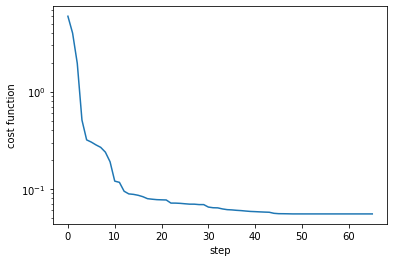

In [26]:
depth = 1

# データ読み込み
x = x_train
t = t_train

# 学習
params = np.random.normal(0, 0.1, [7*depth + 1]) # 最初のパラメータ
maxiter = 100

params_history = []
params_history.append(params)
cost_history = []
cost_history.append(cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}

start = time.perf_counter()
opt = scipy.optimize.minimize(cost, params, method=method,
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()

In [27]:
print('initial parameters:', params_history[0])
print('learnt_parameters:', params_history[-1])

print('-------------------------------')
print('train dataset')

learnt_label_train = np.array([0.0 for i in range(len(t_train))])
for i in range(len(learnt_label_train)):
    learnt_label_train[i] = discriminator(x_train[i], params_history[-1])
learnt_label_train = np.round(learnt_label_train).astype(int)
n_miss_train = sum(abs(t_train - learnt_label_train))

print('teacher label', t_train)
print('learnt label ', learnt_label_train)
print('number of mislabel:', n_miss_train)

print('-------------------------------')
print('test dataset')

learnt_label_test = np.array([0.0 for i in range(len(t_test))])
for i in range(len(learnt_label_test)):
    learnt_label_test[i] = discriminator(x_test[i], params_history[-1])
learnt_label_test = np.round(learnt_label_test).astype(int)
n_miss_test = sum(abs(t_test - learnt_label_test))

print('teacher label', t_test)
print('learnt label ',learnt_label_test)
print('number of mislabel:', n_miss_test)

initial parameters: [-0.05537464 -0.01549411  0.20285781 -0.07913336 -0.0781812  -0.13185869
 -0.09061554 -0.00461672]
learnt_parameters: [-1.91265552 -1.96971055  0.93241506 -0.47729676 -1.84785473 -1.73466665
  3.84075734  8.33451956]
-------------------------------
train dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 0
-------------------------------
test dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 1


## 0 2

In [19]:
iris_dataset = load_iris()
print(iris_dataset['target'])

#2値のみ取ってくる（0-99）
x_data_0 = iris_dataset['data'][0:50]
t_data_0 = iris_dataset['target'][0:50]
x_data_1 = iris_dataset['data'][50:100]
t_data_1 = iris_dataset['target'][50:100]
x_data_2 = iris_dataset['data'][100:150]
t_data_2 = iris_dataset['target'][100:150]
x_data = np.concatenate([x_data_0, x_data_2-1])
t_data = np.concatenate([t_data_0, t_data_2-1])
print(t_data)
print(len(t_data))

# インデックス配列を作成
idx = np.arange(len(x_data))
#np.random.shuffle(idx)
idx_train = idx[idx % 2 == 0]
idx_test = idx[idx % 2 != 0]
# 入力データを訓練データとテストデータに分割
x_train = x_data[idx_train]
x_test = x_data[idx_test]
# クラスデータを訓練データとテストデータに分割
t_train = t_data[idx_train]
t_test = t_data[idx_test]
print(t_train)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
100
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


1 cost 5.330540832032182
2 cost 5.104913722932991
3 cost 2.6345996791084065
4 cost 0.21691294606270076
5 cost 0.1141958479017175
6 cost 0.11194965172485472
7 cost 0.09270361423368094
8 cost 0.0690270123196394
9 cost 0.061279435227975014
10 cost 0.049309214070534055
11 cost 0.03655539242471936
12 cost 0.026497921430589978
13 cost 0.0228432294522005
14 cost 0.008265648499675149
15 cost 0.006290674150687637
16 cost 0.005974943177093859
17 cost 0.005523792700231112
18 cost 0.0054329521325851456
19 cost 0.005284593118747748
20 cost 0.005160719707871317
21 cost 0.005122732358391
22 cost 0.005050792448712876
23 cost 0.004916392295095347
24 cost 0.004216912073486511
25 cost 0.0041388322250937686
26 cost 0.004118780752238674
27 cost 0.004115644568827686
28 cost 0.004099931881411942
29 cost 0.0040741538031438445
30 cost 0.004033495485325015
31 cost 0.003964985314611849
32 cost 0.0038359555267649
33 cost 0.00379129049875829
34 cost 0.003759905293855389
35 cost 0.0037479475969080605
36 cost 0.0037

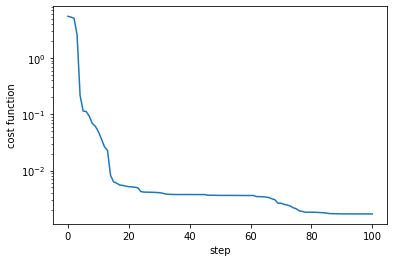

In [20]:
depth = 1

# データ読み込み
x = x_train
t = t_train

# 学習
params = np.random.normal(0, 0.1, [7*depth + 1]) # 最初のパラメータ
maxiter = 100

params_history = []
params_history.append(params)
cost_history = []
cost_history.append(cost(params))

method = "BFGS"
options = {"disp": True, "maxiter": maxiter}

start = time.perf_counter()
opt = scipy.optimize.minimize(cost, params, method=method,
                              callback=lambda x: callback(x), options=options)
end = time.perf_counter()

print('time', end - start, 's')
nit = opt['nit']
plt.plot(np.linspace(0, nit, nit+1), cost_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('cost function')
plt.show()

In [21]:
print('initial parameters:', params_history[0])
print('learnt_parameters:', params_history[-1])

print('-------------------------------')
print('train dataset')

learnt_label_train = np.array([0.0 for i in range(len(t_train))])
for i in range(len(learnt_label_train)):
    learnt_label_train[i] = discriminator(x_train[i], params_history[-1])
learnt_label_train = np.round(learnt_label_train).astype(int)
n_miss_train = sum(abs(t_train - learnt_label_train))

print('teacher label', t_train)
print('learnt label ', learnt_label_train)
print('number of mislabel:', n_miss_train)

print('-------------------------------')
print('test dataset')

learnt_label_test = np.array([0.0 for i in range(len(t_test))])
for i in range(len(learnt_label_test)):
    learnt_label_test[i] = discriminator(x_test[i], params_history[-1])
learnt_label_test = np.round(learnt_label_test).astype(int)
n_miss_test = sum(abs(t_test - learnt_label_test))

print('teacher label', t_test)
print('learnt label ',learnt_label_test)
print('number of mislabel:', n_miss_test)

initial parameters: [-0.03363736 -0.10835122  0.10281575 -0.13201914  0.05225805  0.0706889
  0.09134771  0.03229732]
learnt_parameters: [-3.26238688 -1.47341442  0.09978113 -3.36771892  2.33101369  1.13428736
  0.12725485 10.9654571 ]
-------------------------------
train dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 0
-------------------------------
test dataset
teacher label [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
learnt label  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
number of mislabel: 0
